# Self-shading of two-axis tracking collectors

This document explains how to use the open-source code developed Adam R. Jensen for calculating self-shading of two-axis tracking solar collectors.

Import necessary packages:

In [1]:
import pandas as pd
# The following libraries are not standard and have to be installed seperately.
# It is recommended to install shapely using conda.
import pvlib
from shapely import geometry

In order to import the shading functions from the file *"two_axis_tracker_shading.py"*, the file has to be located in the current working directory. Therefore, before loading the module the current working directory should be changed to the correct folder:

In [2]:
import os
os.chdir('C:/users/arajen/documents/github/twoaxistracking/')
import two_axis_tracker_shading as shading

<br>

Now, the first step is to define the location/site for where shading is to be calculated. The location is used to determine the solar position in the next steps.

In [3]:
location = pvlib.location.Location(latitude=54.9788, longitude=12.2666, elevation=100)

C:\Users\arajen\Anaconda3\lib\site-packages\pvlib\location.py:84: pvlibDeprecationWarning: Arbitrary Location kwargs are deprecated and will be removed in v0.9
  warnings.warn(


<br>

The second step involves determining the series of time steps for which shading shall be calculated for. Generally the time series should cover one year (preferably not a leap year).

The most **important parameter is the frequency**, e.g., '1min', '15min', '1hr', which determines the number of time steps.

It is also important to set the timezone as this affects the calculation of the solar position. It can be recommended to keep all data in UTC to avoid mix-ups.

In [4]:
times = pd.date_range(
    start='2019-1-1 00:00',
    end='2019-12-31 23:59',
    freq='15min',  # Edit the frequecy for a finer or coarser time step
    tz='UTC')

Next, the solar position is calculated from the location for each of the time periods using the `pvlib` package:

In [5]:
df = location.get_solarposition(times)

df.head()  # Print the first 5 lines

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2019-01-01 00:00:00+00:00,146.937480,146.937480,-56.937480,-56.937480,19.592191,-3.195874
2019-01-01 00:15:00+00:00,146.108706,146.108706,-56.108706,-56.108706,25.665116,-3.200828
2019-01-01 00:30:00+00:00,145.078546,145.078546,-55.078546,-55.078546,31.493630,-3.205782
2019-01-01 00:45:00+00:00,143.866070,143.866070,-53.866070,-53.866070,37.053369,-3.210734
2019-01-01 01:00:00+00:00,142.491152,142.491152,-52.491152,-52.491152,42.334286,-3.215687


## Define the collector aperture geometry

In this step, the solar collector geometry is defined:

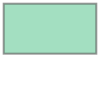

In [6]:
# Change these parameters to suit your particular collector aperture
collector_width = 5.697
collector_height = 3.075

collector_geometry = geometry.box(
    -collector_width/2,  # left x-coordinate
    -collector_height/2,  # bottom y-coordinate
    collector_width/2,  # top y-coordinate
    collector_height/2)  # right x-coordinate

# Example of how to define a circular collector aperture
# centered at the origin (0,0) with a radius of 2
# collector_geometry = geometry.Point(0,0).buffer(2)

collector_geometry

Note, the absolute dimensions do not matter, as the GCR scales the distance between collectors according to the collector area.

<br>

Derive properties from the defined collector geometry:

In [7]:
collector_area = collector_geometry.area
# Calculate the miminum collector distance - sometimes also called D_min
L_min = 2*collector_geometry.hausdorff_distance(geometry.Point(0, 0))

print("Collector area: %2.1f"% collector_area)
print("Collector L_min: %1.2f"% L_min)

Collector area: 17.5
Collector L_min: 6.47


## Field layout definition

Once the collector aperture has been determined, the field layout can be defined. It is important to specify the ground cover ratio (GCR), which is the ratio of the collector are to the ground area.

#### Neighbor oder
The neighbor order determines how many collectors to take into account, for a neighbor order of 1 the immidiate 8 collectors are considered, whereas for a neighbor order of 2, 24 shading collectors are considered. It is recommended to use a neighbor order of 2.

#### Standard vs. custom field layouts
It is possible to choose from four different standard field layouts: `square`, `diagonal`, `hexagon_e_w`, and `hexagon_n_s`.

It is also possible to specify a custom layout using the keywords: `aspect ratio`, `offset`, `rotation`, and `gcr`. For documentation of the layout parameters, see the paper by [Cumpston and Pye (2014)](https://doi.org/10.1016/j.solener.2014.06.012) or check out the function documentation.

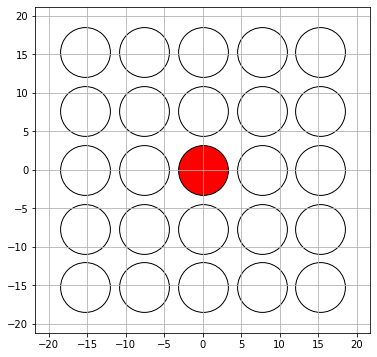

In [8]:
X, Y, tracker_distance, relative_azimuth = \
    shading.generate_field_layout(
        gcr=0.3,  # Change this parameter according to your desired collector density
        neighbor_order=2,
        layout_type='square',
        L_min=L_min,  # calculated from collector geometry - do not change
        collector_area=collector_area,  # calculated from collector geometry - do not change
        plot=True)

## Calculate shading fraction

Now that the collector geometry and field layout have been defined, it is time to do the actual shading calculations. This step is relatively computational intenseive (5 sec. - 3 min.) depdening on the time step, neighbor order, and computational resources available.

In [9]:
%%time
df['shading_fraction'] = \
    df.apply(lambda x: shading.two_axis_shading_fraction(
    solar_azimuth=x['azimuth'],
    solar_elevation=x['elevation'],
    collector_geometry=collector_geometry,
    tracker_distance=tracker_distance,
    relative_azimuth=relative_azimuth,
    L_min=L_min,
    plot=False),
             axis=1)

Wall time: 12 s


## Visualize the shading fraction

Plot the shading fraction for one example day:

(0.0, 61.7993734783575)

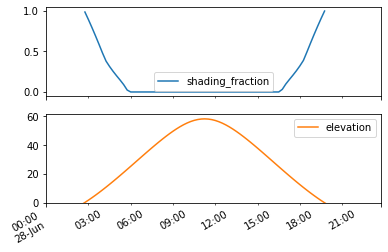

In [10]:
axes = df.loc['2019-06-28':'2019-06-28', ['shading_fraction','elevation']].plot(subplots=True)
axes[1].set_ylim(0,None)

<br>

Visualize the average daily shading fraction:

<AxesSubplot:>

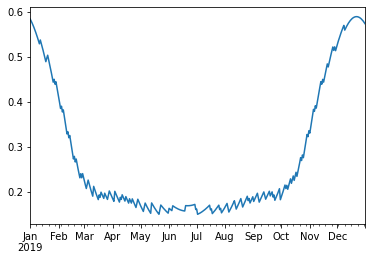

In [11]:
df['shading_fraction'].resample('1d').mean().plot()

Export the shading fraction time series:

In [12]:
columns_to_save = ['shading_fraction', 'azimuth', 'apparent_zenith']

# Set the night time shading fraction to 1 (completly shaded)
df.loc[df['shading_fraction'].isna(), 'shading_fraction'] = 1

filename = 'test_file.csv'

# Export the data to a tab seperated ('\t') csv file 
# Represent nan values in shading fraction as 1
df[columns_to_save].to_csv(filename, sep='\t', index=False)